In [1]:
using Revise
using BenchmarkTools
using Profile
using LinearAlgebra
using JLD2

using StellaratorNearAxis
using CairoMakie

# StellaratorNearAxis.jl Example
This example of StellaratorNearAxis.jl can also be found in the
[GitHub examples folder](https://github.com/maxeruth/StellaratorNearAxis.jl/tree/main/examples/)
## Part 1: Initialize via coils
To begin, we demonstrate the initialization of the near-axis expansion from coils.
We have two coil sets: a [rotating ellipse](https://github.com/rogeriojorge/rotating_ellipse_VMEC)
and [Landreman-Paul](https://arxiv.org/abs/2108.03711).

In [2]:
##########################################
# (0) Parameters we use for the expansion
##########################################

Nrho = 6    # Order of the expansion (Paper plots run with 10)
Mcoil = 50  # Number of quadrature points for the coils (Paper plots were performed with 200)
Ms = 201;   # Number of s-modes (currently must be odd. Paper plots run with 201)
Mc = 2Ms+3  # Number of s-collocation points
K_reg = Inf # Characteristic wavenumber of regularization (use K_reg=Inf for no regularization)
N_reg = 2   # Exponent of regularization (appears as a ∂ₛ²ᴺ term in the PDE)


###################################
# (1) Load the optimized coil files
###################################
dir = abspath(joinpath(pathof(StellaratorNearAxis), "../../examples"))
coil_file_lp = "$(dir)/landreman_paul_biot_savart_opt.json"
coil_file_re = "$(dir)/rotating_ellipse_biot_savart_opt.json"

coils_lp = load_coils(coil_file_lp, Mcoil);
coils_re = load_coils(coil_file_re, Mcoil);

########################################
# (2) Find an initial point on the axis
########################################

# These are points on the magnetic axis up to O(1e-12)
# See the code below to find points if it is unknown (e.g., if Mcoil changes).
# However, find_magnetic_axis takes a few seconds to run (this could likely be
# dramatically improved with simpler coils and a different aglorithm)
x0_re = [1.0015648906914234,0.,0.]
x0_lp = [1.2124870110559867,0.,0.]

# x0_guess_re = [1.0,0.,0.]
# x0_guess_lp = [1.2,0.,0.]
# x0_re = find_magnetic_axis(x0_guess_re, coils_re; tol=1e-12)
# x0_lp = find_magnetic_axis(x0_guess_lp, coils_lp; tol=1e-12)

###########################################
# (3) Get the axes from the initial points
###########################################
r0_re = axis_from_point(x0_re, coils_re, Ms, Mc; tol=1e-12);
r0_lp = axis_from_point(x0_lp, coils_lp, Ms, Mc; tol=1e-12);

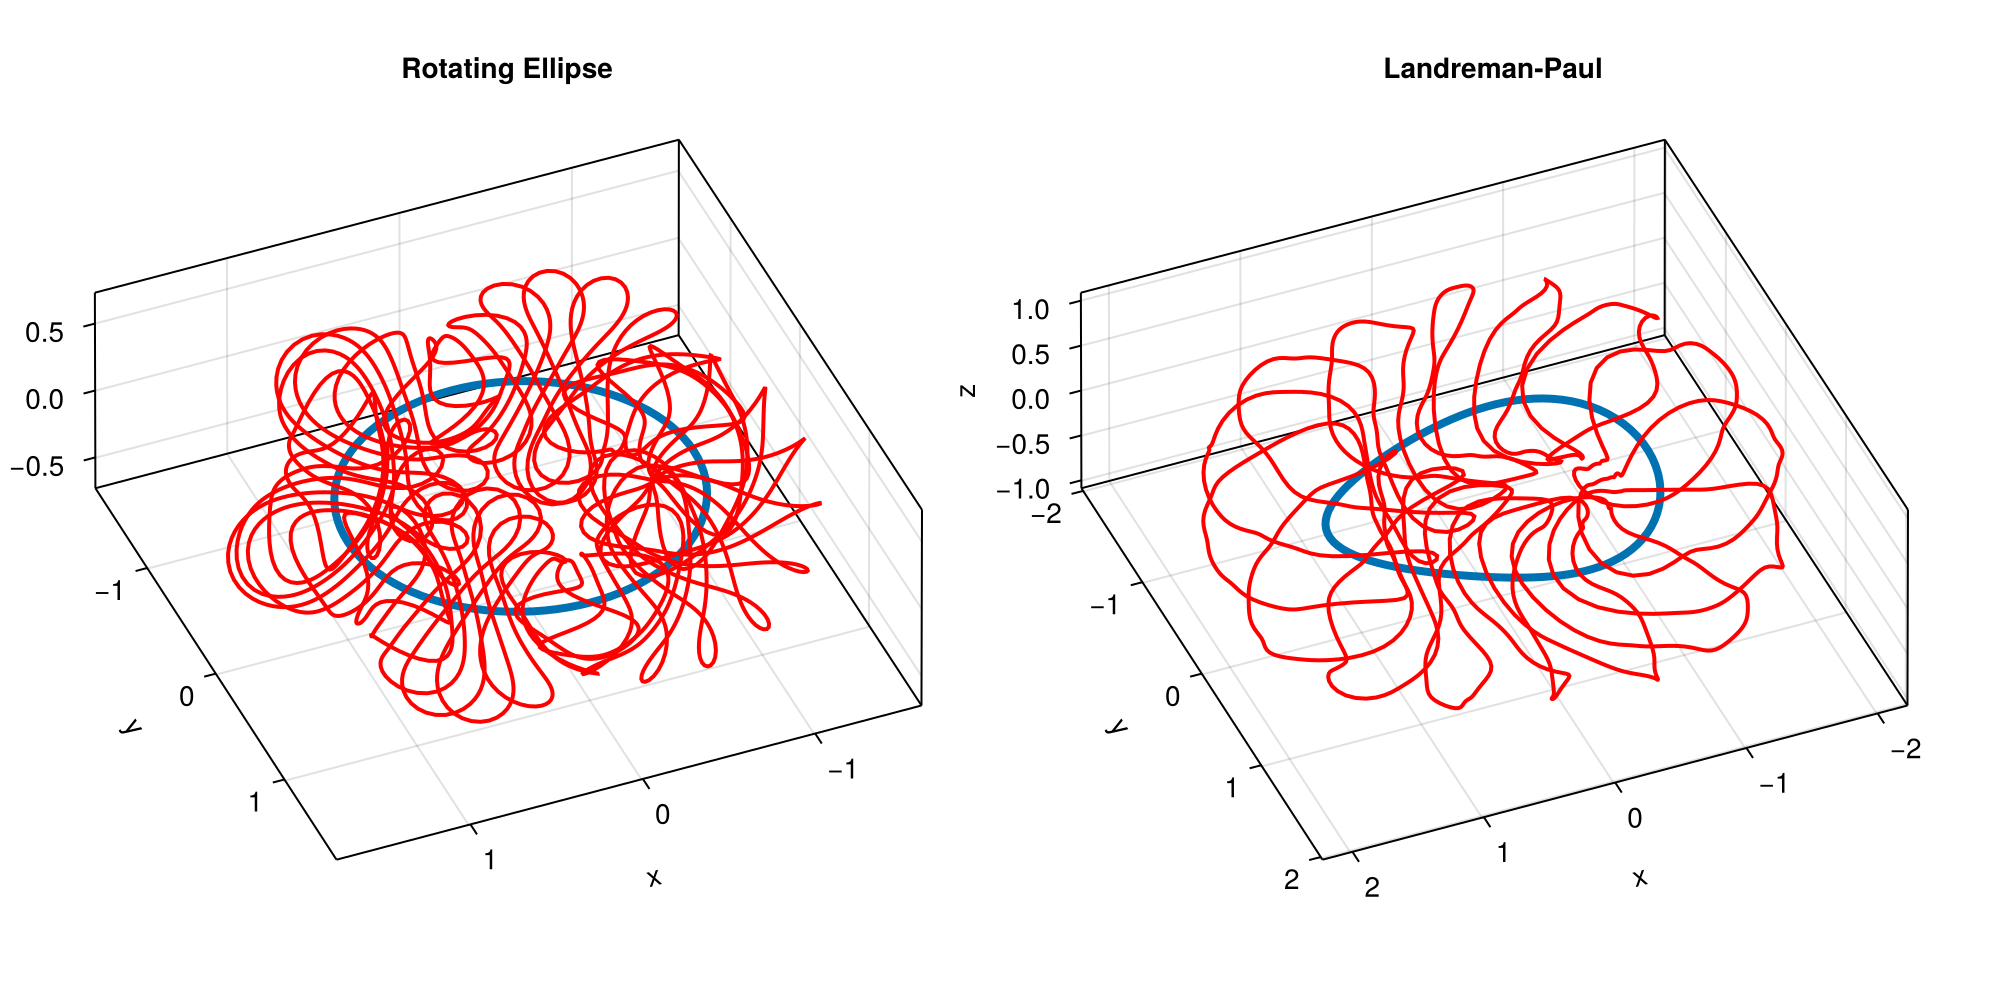

In [3]:
# Let's plot the coils and the magnetic axis
Mp = 100;
lw = 2

coilses = [coils_re, coils_lp]
r0s = [r0_re, r0_lp]
titles = ["Rotating Ellipse", "Landreman-Paul"]
f = Figure(size = (1000,500))

for jj = 1:2
    ax = Axis3(f[1,jj], aspect=(2,2,0.8),elevation=3.5π/16,azimuth=3π/8, title=titles[jj])
    plot_curve!(ax, r0s[jj], Mp; linewidth=2lw)

    coils = coilses[jj]
    Ncoil = length(coils)

    for ii = 1:Ncoil
        plot_curve!(ax, coils[ii].r0_s, Mp; color=:red, linewidth=lw)
    end
end

f

## Part 2: Solve the Near-Axis Expansion
Given the axis and the coils, we can now find a magnetic field and solve the near-axis expansion.

In [4]:
###############################################
# (1) Expand the magnetic field about the axis
###############################################
B_re, _ = get_field_on_axis(r0_re, coils_re, Mc, Nrho, Mcoil);
B_lp, _ = get_field_on_axis(r0_lp, coils_lp, Mc, Nrho, Mcoil);

###################################################################
# (2) Get the near-axis equilibrium struct from the magnetic field
###################################################################
nae_re = field_to_nae(r0_re, B_re, Mc, K_reg, N_reg);
nae_lp = field_to_nae(r0_lp, B_lp, Mc, K_reg, N_reg);

#######################################
# (3) Get Initial data from equilibria
#######################################
ϕ_IC_re = get_IC_from_eq(nae_re);
ϕ_IC_lp = get_IC_from_eq(nae_lp);

###################################################
# (4) Rerun the vacuum solve with the initial data
###################################################
vacuum_solve(nae_re, ϕ_IC_re);
vacuum_solve(nae_lp, ϕ_IC_lp);

##############################
# (5) Solve for flux surfaces
##############################
get_flux_coordinates(nae_re)
get_flux_coordinates(nae_lp)

## Part 3: Results
Now, we can check the results!

We will plot two things: flux surfaces and the error of the magnetic field on a line from the axis.
For the flux surfaces, we provide two routines:

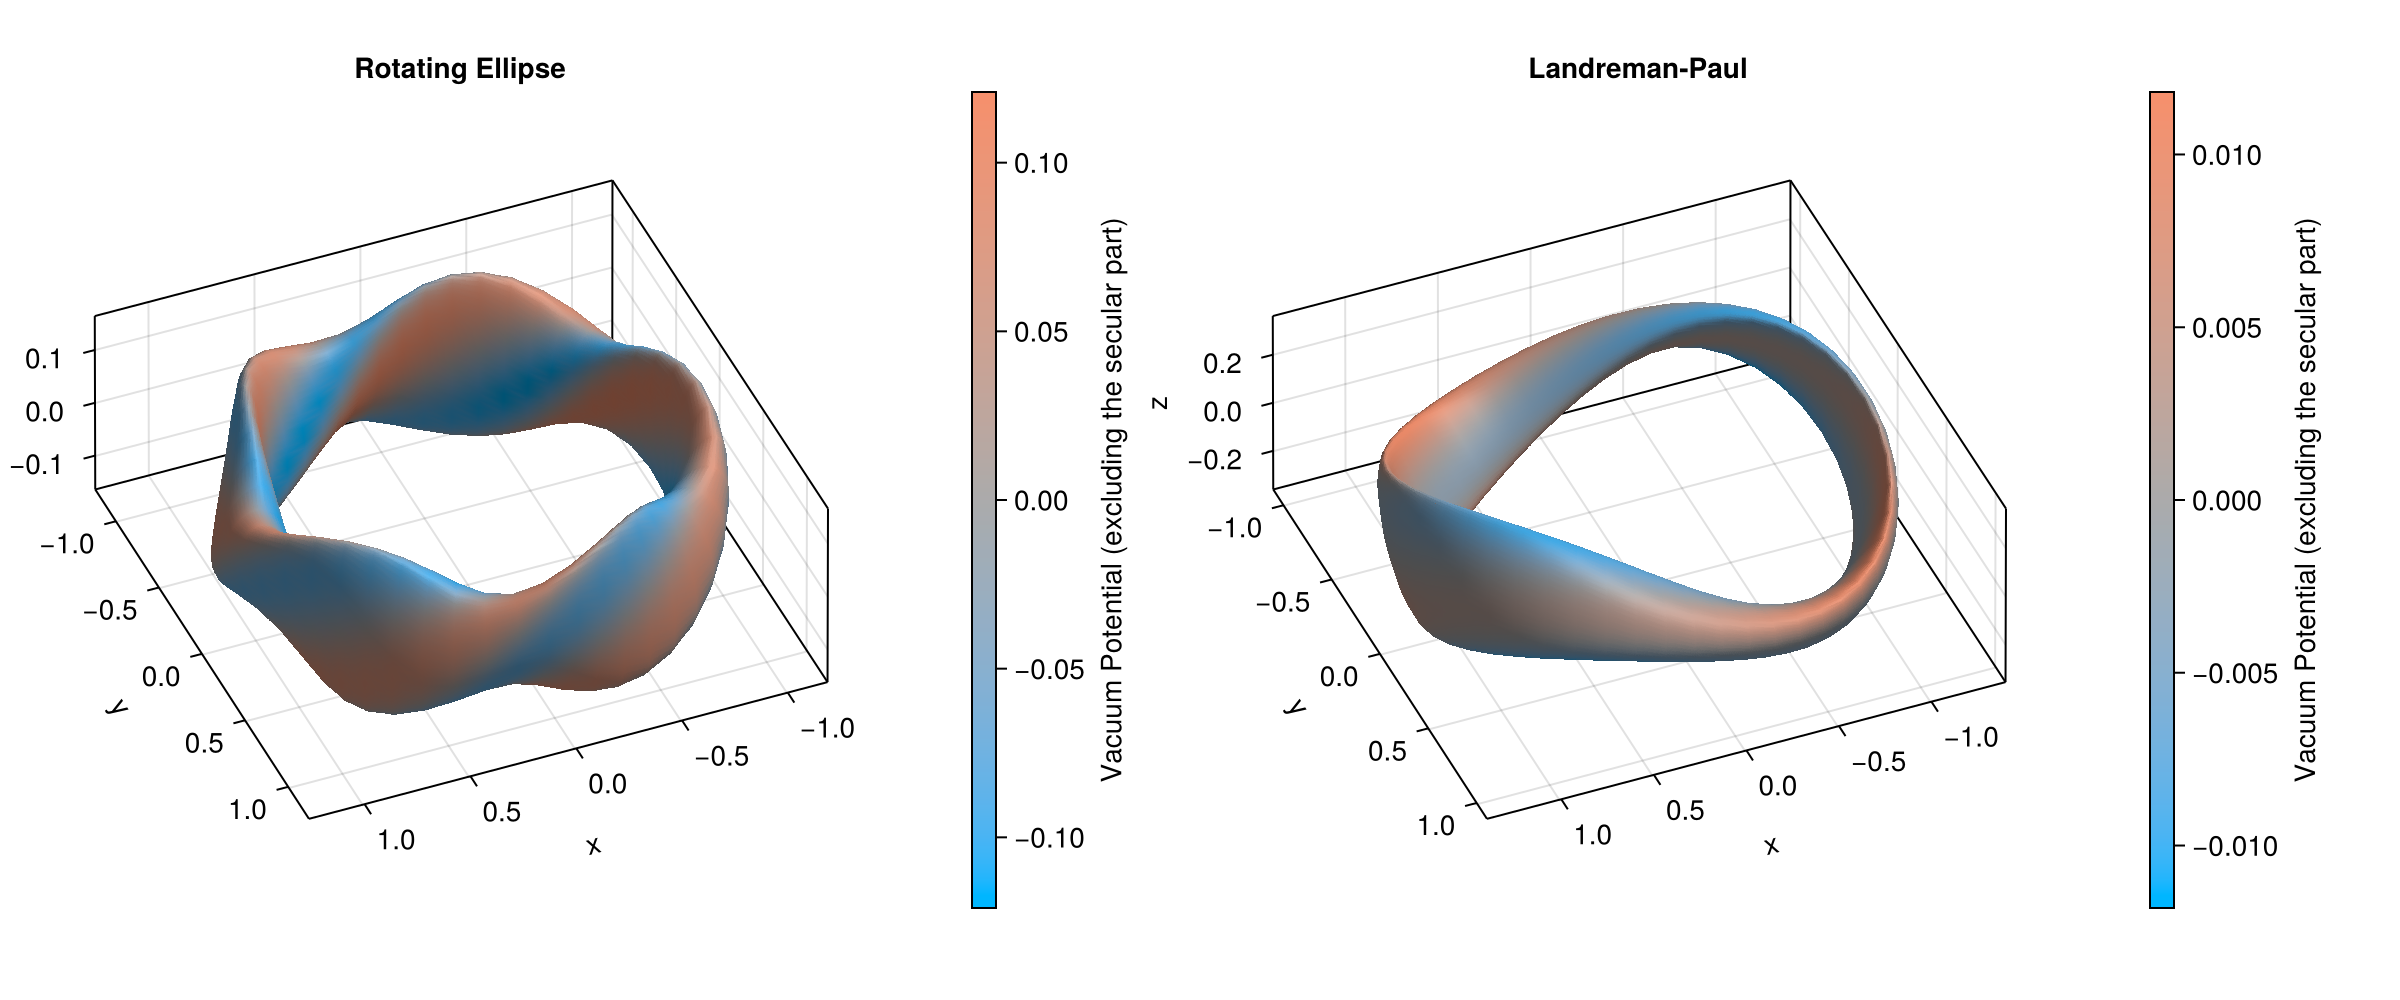

In [5]:
########################
# (1) Plot a 3D surface
########################
f = Figure(size=(1200,500))
naes = [nae_re, nae_lp]
titles = ["Rotating Ellipse", "Landreman-Paul"]

# The point determining which surface we plot:
rho0s = [0.15,0.05]
theta0 = 0.
s0 = 0.

# The quantity we plot on the surface:
us = [nae_re.phi_s, nae_lp.phi_s]
clabel = "Vacuum Potential (excluding the secular part)"
coilses = [coils_re, coils_lp]

# Plotting
for jj = 1:2
    ax = Axis3(f[1,2jj-1], aspect=(2,2,0.8),elevation=3.5π/16,azimuth=3π/8, title=titles[jj])
    nae = naes[jj]
    p = flux_surface_plot!(ax, nae, us[jj], rho0s[jj], theta0, s0)

    ### Uncomment to plot coils
    ### Note: CairoMakie does not currently support z-ordering, so coils do not wrap the equilibrium
    # coils = coilses[jj]
    # Ncoil = length(coils)

    # for ii = 1:Ncoil
    #     plot_curve!(ax, coils[ii].r0_s, Mp; color=:magenta, linewidth=lw)
    # end

    gl = GridLayout(f[1,2jj],width=60)
    Colorbar(gl[1,1],p,label=clabel)
end
f

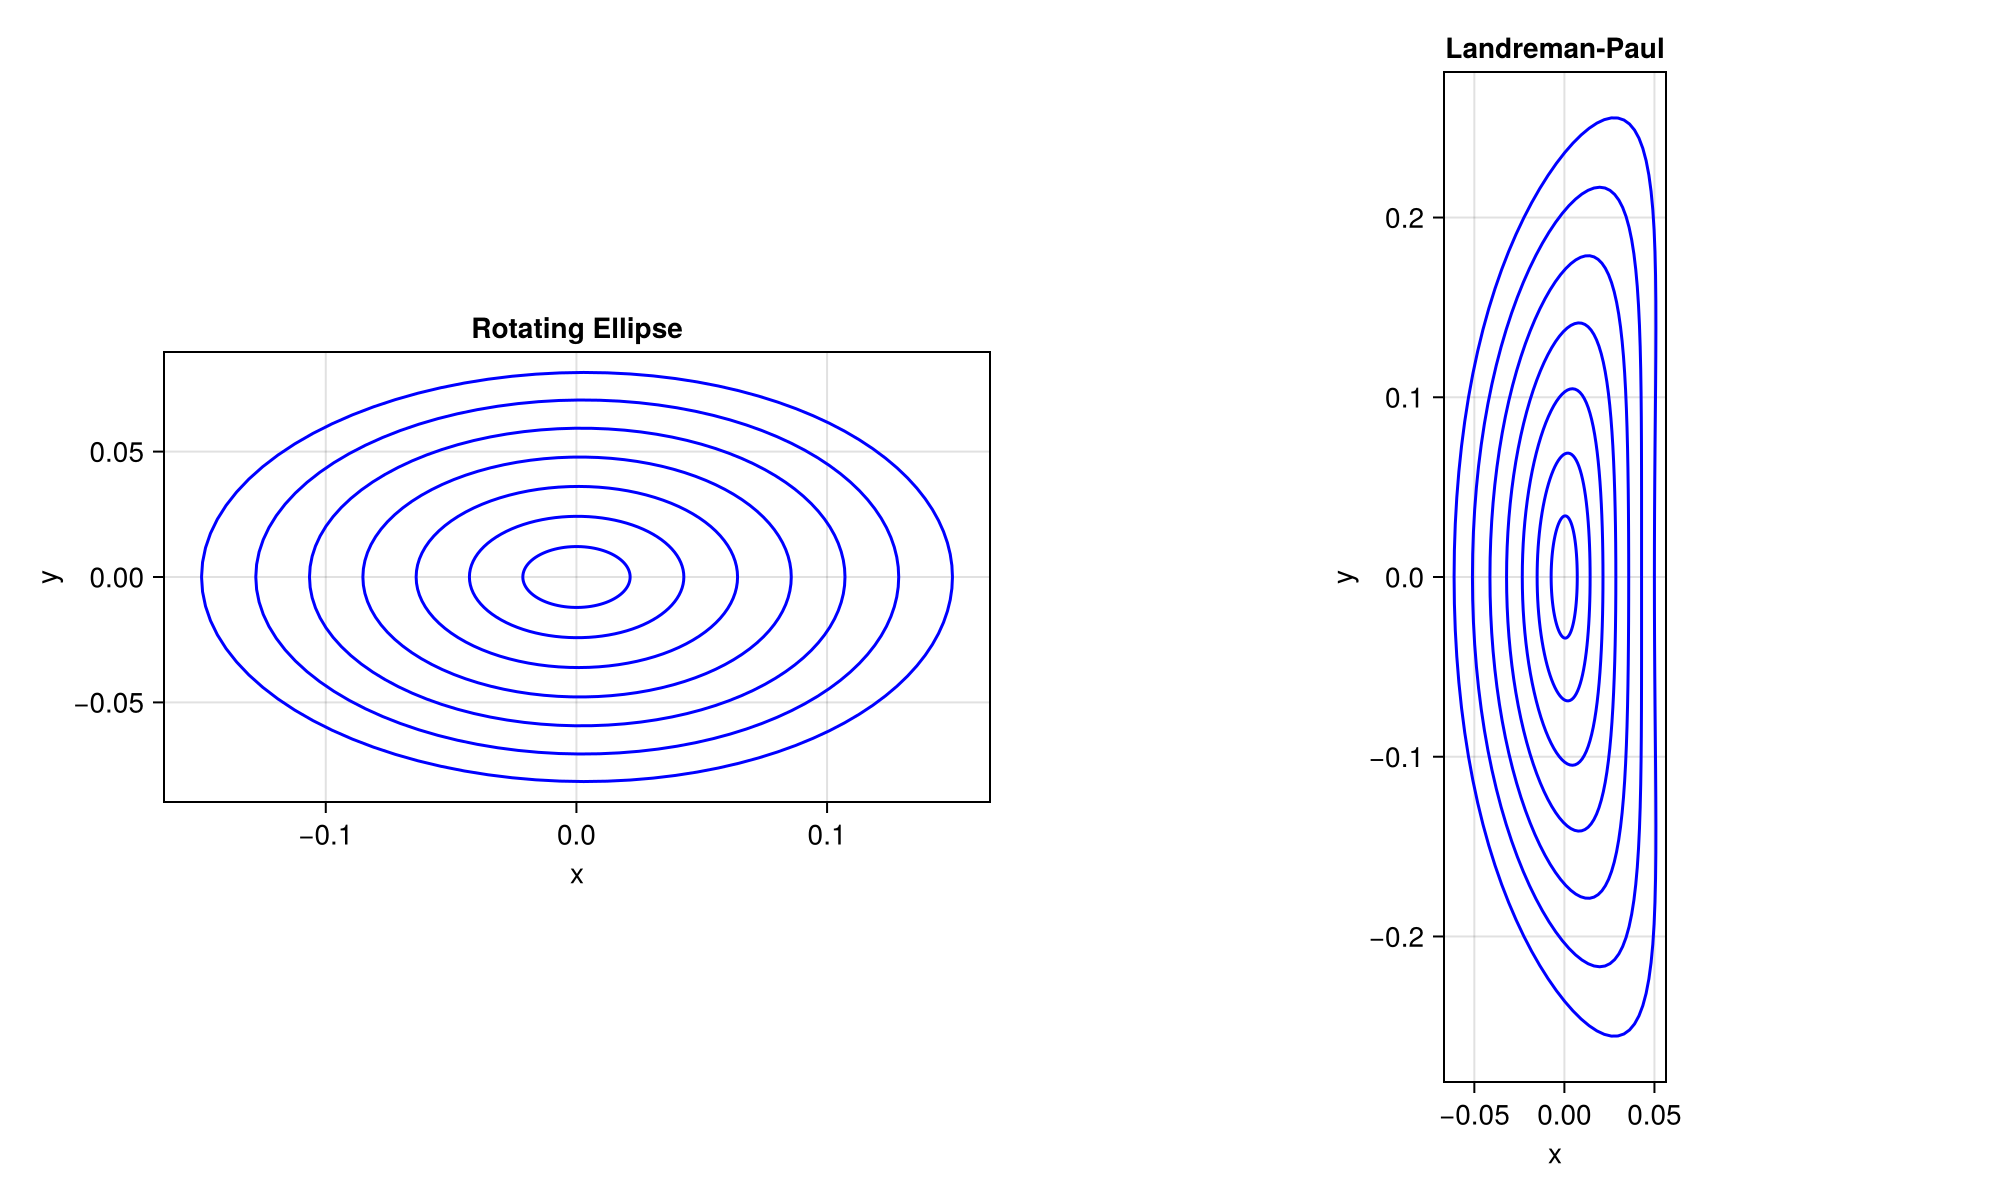

In [6]:
#####################################
# (2) Plot cross section of surfaces
#####################################

f = Figure(size=(1000,600))
naes = [nae_re, nae_lp]
titles = ["Rotating Ellipse", "Landreman-Paul"]

# The point determining which surface we plot:
rho0s = [0.15,0.05] # Defines the maximum radius in the theta0 direction
theta0 = 0.
s0 = 0.             # Defines the cross section

# Number of surfaces:
Nsurf = 7

# Plotting
for jj = 1:2
    ax = Axis(f[1,jj], aspect=DataAspect(), title=titles[jj], xlabel="x", ylabel="y")
    nae = naes[jj]
    flux_contours!(ax, nae.xi_s, rho0s[jj], theta0, s0, Nsurf; color=:blue)
end
f

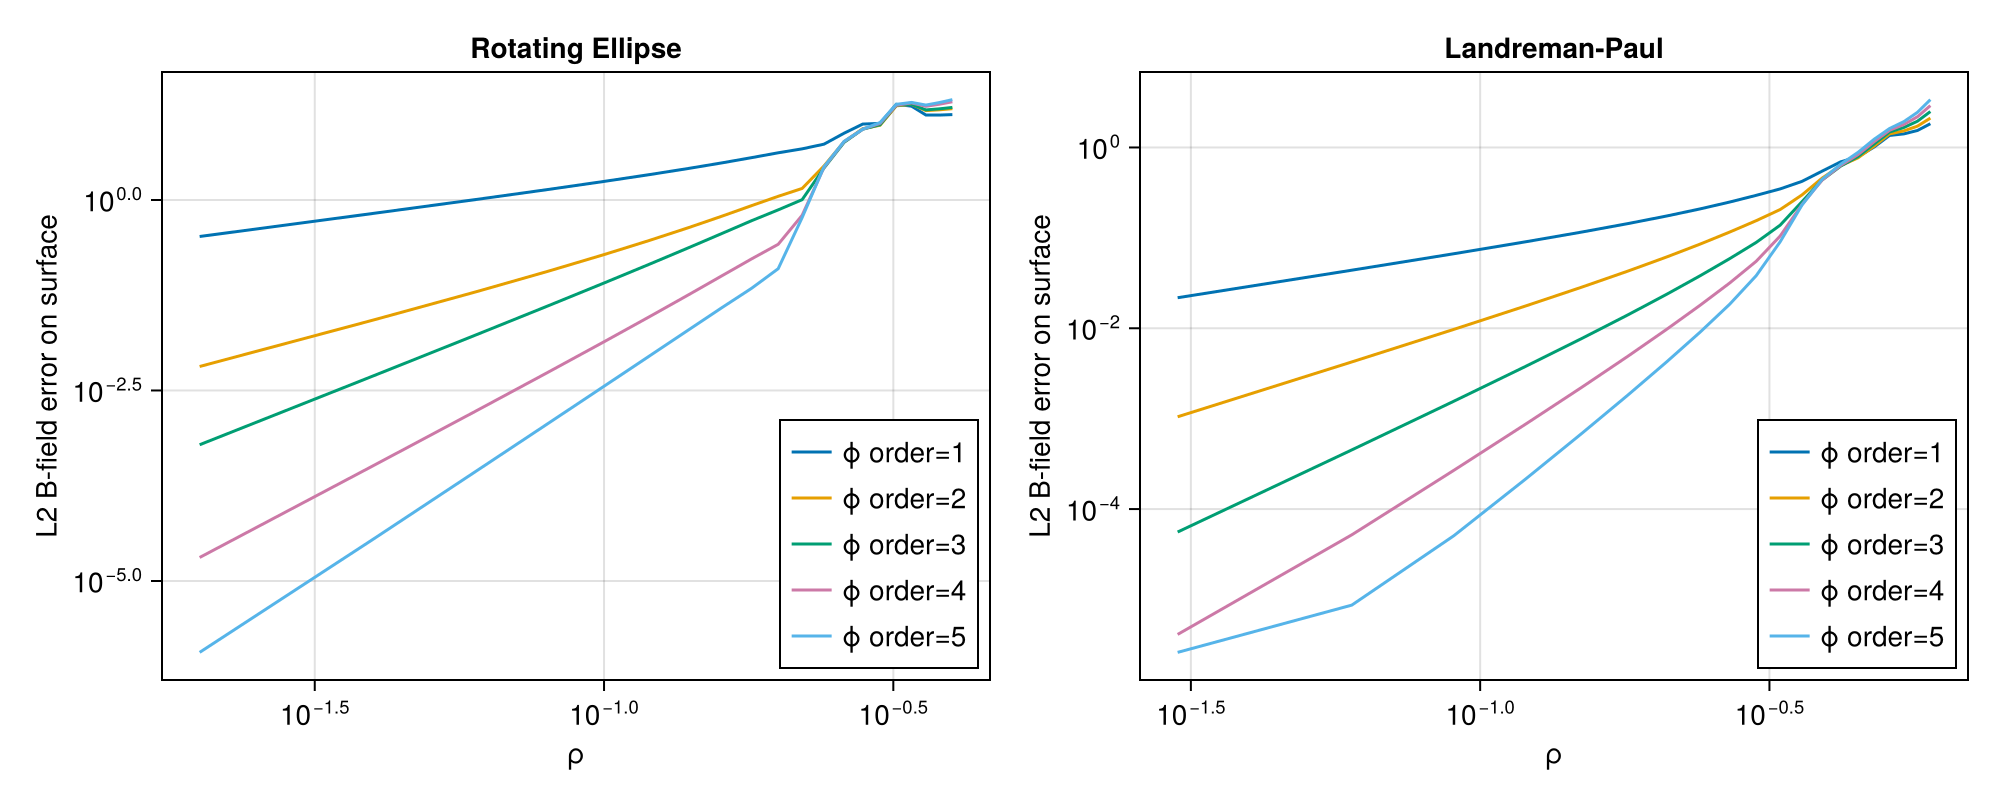

In [7]:
###########################
# (3) Magnetic field error
###########################

naes = [nae_re, nae_lp]
coilses = [coils_re, coils_lp]
titles = ["Rotating Ellipse", "Landreman-Paul"]

# We evaluate the magnetic field error, as compared to the coils, via an L2 norm
rho0s = [0.4,0.6] # Defines the maximum radius we evaluate the field at
Nr = 20            # Number of rho surfaces
Ntheta = 10        # (Ntheta, Ns) is resolution to evaluate at on the surfaces
Ns = 10

thetas = (0:Ntheta-1) .* (2π/Ntheta)
ss = (0:Ns-1) .* (2π/Ns)

f = Figure(size=(1000,400))

for i_conf = 1:2
    nae = naes[i_conf]
    coils = coilses[i_conf]
    rhos = (1:Nr) .* (rho0s[i_conf]/Nr)

    ax = Axis(f[1,i_conf], title=titles[i_conf], xscale=log10, yscale=log10, xlabel="ρ", ylabel="L2 B-field error on surface")

    # Evaluate the magnetic field
    r = r0_to_r(nae.r0_s, nae.Q_s) # The position function
    rs = zeros(3,Nr*Ntheta*Ns)
    for ii = 1:3
        rs[ii,:] = evaluate(r[ii], rhos, thetas, ss)[:]
    end
    Bcoil = reshape(evaluate(rs,coils),3,Nr,Ntheta,Ns)


    # Get the derivative of the position for pushing forward the magnetic field
    # i.e., B = dqdr * dphi/dq = (drdq) \ (dphi/dq)
    drdq = zeros(3,3,Nr,Ntheta,Ns)
    for ii = 1:3
        drdq[ii,1,:,:,:] = evaluate(rho_deriv(r[ii]), rhos, thetas, ss)
        drdq[ii,2,:,:,:] = evaluate(theta_deriv(r[ii]), rhos, thetas, ss)
        drdq[ii,3,:,:,:] = evaluate(s_deriv(r[ii]), rhos, thetas, ss)
    end

    for n = 2:Nrho
        # Get the order-(n-1) field
        B_s = change_order.(nae.B_s, n)
        Bnae = zeros(3,Nr,Ntheta,Ns)
        for ii = 1:3
            Bnae[ii,:,:,:] = evaluate(B_s[ii], rhos, thetas, ss)
        end

        # Transform the field to cartesian elements
        for ii = 1:Nr, jj = 1:Ntheta, kk = 1:Ns
            Bnae[:,ii,jj,kk] = drdq[:,:,ii,jj,kk]' \ Bnae[:,ii,jj,kk]
        end

        # Take L2 norm
        err = [norm(Bcoil[:,ii,:,:] - Bnae[:,ii,:,:]) ./ sqrt(Ntheta*Ns) for ii = 1:Nr]

        # Plot
        lines!(rhos, err, label="ϕ order=$(n-1)")
    end
    axislegend(position=:rb)
end
f

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*